In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Auxiliar Functions

In [34]:
#Useful functions
def missing_percentage(df):
    return (df.isna().sum() / len(df)) * 100

def describe2(df):
    # Solo columnas numéricas
    df_numeric = df.select_dtypes(include=['number'])

    # Estadísticas básicas
    desc = df_numeric.describe()

    # Renombrar el cuartil 50% como "50% (Median)"
    desc.rename(index={'50%': '50% (Median)'}, inplace=True)

    # Agregar skewness y curtosis
    desc.loc['skew'] = df_numeric.skew()
    desc.loc['kurtosis'] = df_numeric.kurtosis()

    # Agregar todas las modas como string separados por coma
    mode_values = df_numeric.mode()
    mode_strs = []
    for col in df_numeric.columns:
        modes = mode_values[col].dropna().tolist()
        mode_str = ', '.join(map(str, modes))
        mode_strs.append(mode_str)
    desc.loc['mode'] = mode_strs

    # Reordenar filas: colocar 'mode' justo después de 'count'
    orden_deseado = ['count', 'mode'] + [i for i in desc.index if i not in ['count', 'mode']]
    desc = desc.loc[orden_deseado]

    # Transponer
    return desc.T

import matplotlib.pyplot as plt
import math

def barplots_for_categoricals(df, columns=None, n_cols=2, figsize_per_plot=(5, 4)):
    """
    Dibuja gráficos de barras para variables categóricas en un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        El DataFrame que contiene los datos.
    columns : list or None, opcional
        Lista de columnas a graficar. Si es None, se seleccionan automáticamente
        todas las columnas categóricas (object, category, bool).
    n_cols : int, opcional
        Número de columnas en el grid de subplots. Default=2.
    figsize_per_plot : tuple, opcional
        Tamaño de cada gráfico individual (ancho, alto). Default=(5, 4).
    """

    # Selección de columnas
    if columns is not None:
        cat_cols = [col for col in columns if col in df.columns]
        if not cat_cols:
            print("No matching columns found in DataFrame.")
            return
    else:
        df_cat = df.select_dtypes(include=['object', 'category', 'bool'])
        cat_cols = df_cat.columns.tolist()

    num_plots = len(cat_cols)
    if num_plots == 0:
        print("No categorical variables found.")
        return

    # Calcular número de filas
    n_rows = math.ceil(num_plots / n_cols)

    # Crear subplots
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * figsize_per_plot[0], n_rows * figsize_per_plot[1])
    )
    axes = axes.flatten()

    # Iterar columnas categóricas
    for i, col in enumerate(cat_cols):
        ax = axes[i]
        counts = df[col].value_counts(dropna=False)
        bars = ax.bar(counts.index.astype(str), counts.values, color='skyblue')

        # Títulos y etiquetas
        ax.set_title(col)
        ax.set_ylabel('Count')
        ax.set_xticks(range(len(counts.index)))
        ax.set_xticklabels(counts.index.astype(str), rotation=45, ha='right')

        # Padding en Y
        max_height = max(counts.values)
        ax.set_ylim(0, max_height * 1.10)

        # Anotar valores en las barras
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Ocultar subplots no usados
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

import pandas as pd

def save_df_to_csv(df, filename, sep=",", index=False, encoding="utf-8", date_cols=None):
    """
    Guarda un DataFrame en un archivo CSV con formato de fecha DD/MM/YYYY HH:MM (sin segundos).

    Parámetros
    ----------
    df : pandas.DataFrame
        El DataFrame a guardar.
    filename : str
        Nombre (y ruta opcional) del archivo de salida.
    sep : str, opcional
        Separador de columnas. Default=",".
    index : bool, opcional
        Incluir índice en el CSV. Default=False.
    encoding : str, opcional
        Codificación. Default="utf-8".
    date_cols : list or None
        Lista de columnas de tipo fecha a formatear como "DD/MM/YYYY HH:MM".
        Si None, no se formatea ninguna.
    """
    df_copy = df.copy()

    if date_cols is not None:
        for col in date_cols:
            if col in df_copy.columns and pd.api.types.is_datetime64_any_dtype(df_copy[col]):
                df_copy[col] = df_copy[col].dt.strftime("%d/%m/%Y %H:%M")

    try:
        df_copy.to_csv(filename, sep=sep, index=index, encoding=encoding)
        print(f"✅ DataFrame guardado exitosamente en: {filename}")
    except Exception as e:
        print(f"❌ Error al guardar el DataFrame: {e}")

def plot_kde_hist(df):
    # Solo columnas numéricas
    df_numeric = df.select_dtypes(include='number')

    # Número de columnas numéricas
    num_cols = df_numeric.shape[1]

    # Crear subplots (ajusta el número de filas/columnas según lo que necesites)
    fig, axes = plt.subplots(nrows=math.ceil(num_cols/3), ncols=3, figsize=(10, 8))

    # Si solo hay una columna, axes no es un array
    if num_cols == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    # Generar gráfico KDE por cada columna
    for ax, col in zip(axes, df_numeric.columns):
        sns.kdeplot(data=df_numeric[col].dropna(), ax=ax, fill=True)
        ax.set_title(f'Distribución KDE: {col}')
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def boxplots(df, n_cols=3, figsize_per_plot=(4, 4)):
    # Seleccionar columnas numéricas
    df_numeric = df.select_dtypes(include='number')
    num_plots = len(df_numeric.columns)

    # Calcular filas necesarias
    n_rows = math.ceil(num_plots / n_cols)

    # Crear figura y subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * figsize_per_plot[0], n_rows * figsize_per_plot[1]))
    axes = axes.flatten()  # Para indexar fácilmente, aunque sea 1D

    for i, col in enumerate(df_numeric.columns):
        ax = axes[i]
        ax.boxplot(df_numeric[col].dropna(), orientation='horizontal', patch_artist=True)
        ax.set_title(f'{col}')
        ax.set_ylabel('Valor')
        ax.grid(True)

    # Ocultar subplots vacíos si los hay
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

def drop_outliers_iqr_global(df, col, k=1.5, return_mask=False):
    """Elimina outliers de `col` con IQR global (sin agrupar)."""
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    mask = df[col].isna() | df[col].between(lo, hi)
    if return_mask:
        return mask, (lo, hi)
    return df[mask].copy(), (lo, hi)

#Loading Data

In [35]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLOps/Proyecto/Dataset/steel_energy_modified.csv')

In [36]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.0,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.5,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


In [37]:
df2 = df.copy()

#Numeric Variables

In [38]:
# Convert 'date' column to datetime
df2['date'] = pd.to_datetime(df['date'].str.strip(), format='%d/%m/%Y %H:%M', errors='raise')

In [39]:
numeric_cols = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']

for col in numeric_cols:
    df2[col] = pd.to_numeric(df2[col].replace(['invalid', '?', 'error', ' NAN ', ' ? ', ' null ', ' ERROR ', ' n/a ', ' INVALID '], np.nan), errors='coerce')

In [40]:
df2.drop(columns=['mixed_type_col'], inplace=True)

In [41]:
df2['NSM'] = df2['NSM'].astype('Int64')

In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35740 entries, 0 to 35739
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35378 non-null  datetime64[ns]
 1   Usage_kWh                             35224 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35210 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35186 non-null  float64       
 4   CO2(tCO2)                             35230 non-null  float64       
 5   Lagging_Current_Power_Factor          35168 non-null  float64       
 6   Leading_Current_Power_Factor          35214 non-null  float64       
 7   NSM                                   35185 non-null  Int64         
 8   WeekStatus                            35400 non-null  object        
 9   Day_of_week                           35428 non-null  object        
 10

In [43]:
# To investigate the missing data percentage. All columns have missing data
missing_percentage(df2)

,0
date,1.012871
Usage_kWh,1.443760
Lagging_Current_Reactive.Power_kVarh,1.482932
Leading_Current_Reactive_Power_kVarh,1.550084
CO2(tCO2),1.426973
Lagging_Current_Power_Factor,1.600448
Leading_Current_Power_Factor,1.471740
NSM,1.552882
WeekStatus,0.951315
Day_of_week,0.872971


In [44]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
date,35378,2018-07-02 14:56:25.595567872,2018-01-01 00:00:00,2018-04-02 06:48:45,2018-07-02 14:52:30,2018-10-01 21:26:15,2018-12-31 23:45:00,NaN
Usage_kWh,35224.0,39.400143,0.0,3.24,4.61,52.06,34899.48,276.516063
Lagging_Current_Reactive.Power_kVarh,35210.0,18.734507,0.0,2.3,5.0,23.33,6145.92,89.876721
Leading_Current_Reactive_Power_kVarh,35186.0,7.617218,0.0,0.0,0.0,2.59,2301.84,55.10866
CO2(tCO2),35230.0,2.635854,0.0,0.0,0.0,0.02,1364.04,41.636508
Lagging_Current_Power_Factor,35168.0,101.634809,0.0,63.55,88.21,99.46,9900.0,316.378288
Leading_Current_Power_Factor,35214.0,109.390282,0.0,99.7225,100.0,100.0,9800.0,371.783664
NSM,35185.0,52646.198664,0.0,21600.0,43200.0,64800.0,7783200.0,192885.357686


In [45]:
describe2(df2)

,count,mode,mean,std,min,25%,50% (Median),75%,max,skew,kurtosis
Usage_kWh,35224.0,3.06,39.400143,276.516063,0.0,3.24,4.61,52.06,34899.48,69.11708,7524.39692
Lagging_Current_Reactive.Power_kVarh,35210.0,0.0,18.734507,89.876721,0.0,2.3,5.0,23.33,6145.92,27.717697,1189.081346
Leading_Current_Reactive_Power_kVarh,35186.0,0.0,7.617218,55.10866,0.0,0.0,0.0,2.59,2301.84,17.898318,405.018552
CO2(tCO2),35230.0,0.0,2.635854,41.636508,0.0,0.0,0.0,0.02,1364.04,17.900662,347.297603
Lagging_Current_Power_Factor,35168.0,100.0,101.634809,316.378288,0.0,63.55,88.21,99.46,9900.0,19.363849,416.491967
Leading_Current_Power_Factor,35214.0,100.0,109.390282,371.783664,0.0,99.7225,100.0,100.0,9800.0,18.568826,377.421001
NSM,35185.0,"75600, 79200",52646.198664,192885.357686,0.0,21600.0,43200.0,64800.0,7783200.0,24.137984,681.616311


array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'Usage_kWh'}>,
        <Axes: title={'center': 'Lagging_Current_Reactive.Power_kVarh'}>],
       [<Axes: title={'center': 'Leading_Current_Reactive_Power_kVarh'}>,
        <Axes: title={'center': 'CO2(tCO2)'}>,
        <Axes: title={'center': 'Lagging_Current_Power_Factor'}>],
       [<Axes: title={'center': 'Leading_Current_Power_Factor'}>,
        <Axes: title={'center': 'NSM'}>, <Axes: >]], dtype=object)

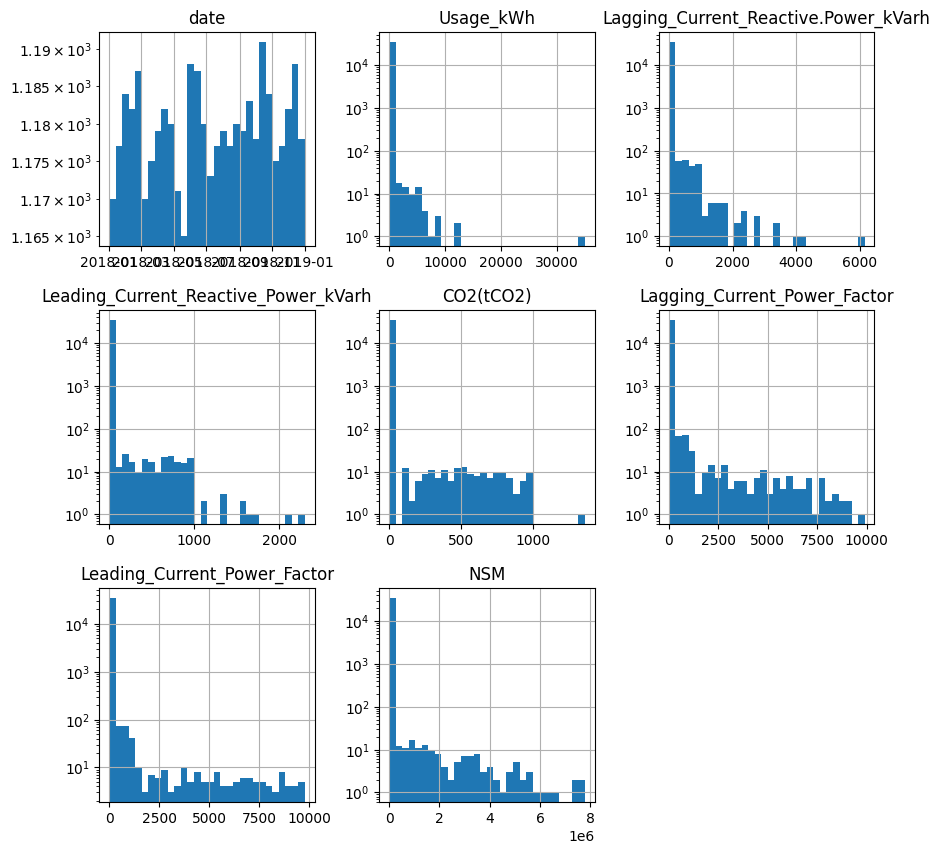

In [46]:
df2.hist(figsize=(10, 10), bins=30, log=True)

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'Usage_kWh'}>,
        <Axes: title={'center': 'Lagging_Current_Reactive.Power_kVarh'}>],
       [<Axes: title={'center': 'Leading_Current_Reactive_Power_kVarh'}>,
        <Axes: title={'center': 'CO2(tCO2)'}>,
        <Axes: title={'center': 'Lagging_Current_Power_Factor'}>],
       [<Axes: title={'center': 'Leading_Current_Power_Factor'}>,
        <Axes: title={'center': 'NSM'}>, <Axes: >]], dtype=object)

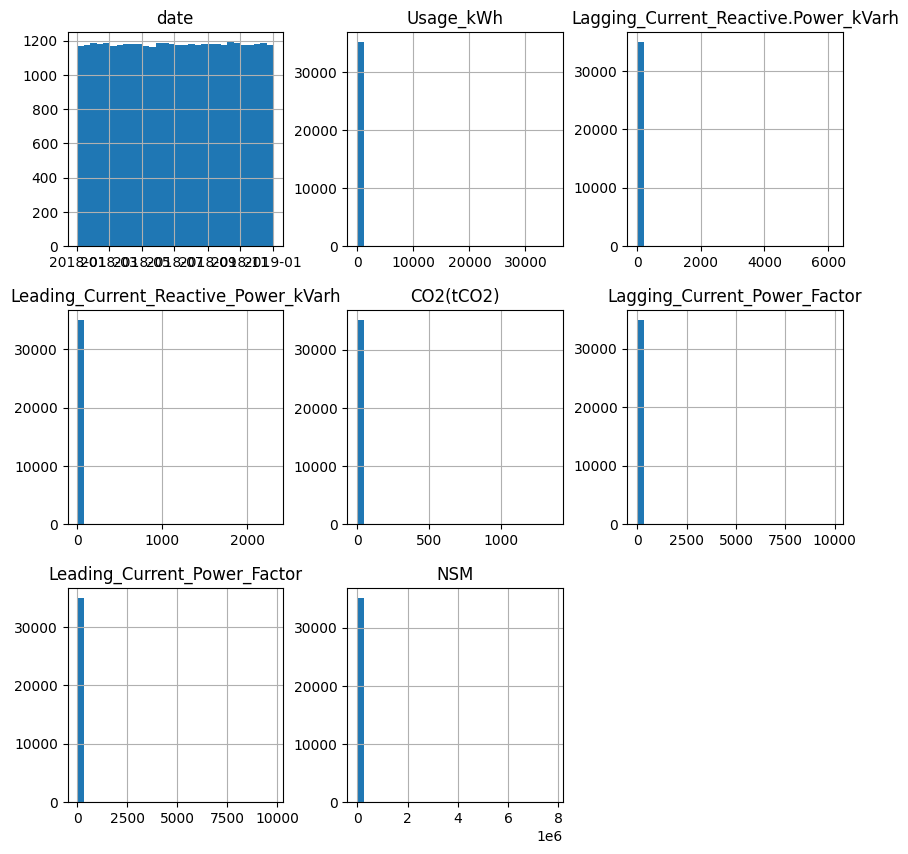

In [47]:
df2.hist(figsize=(10, 10), bins=30, log=False)

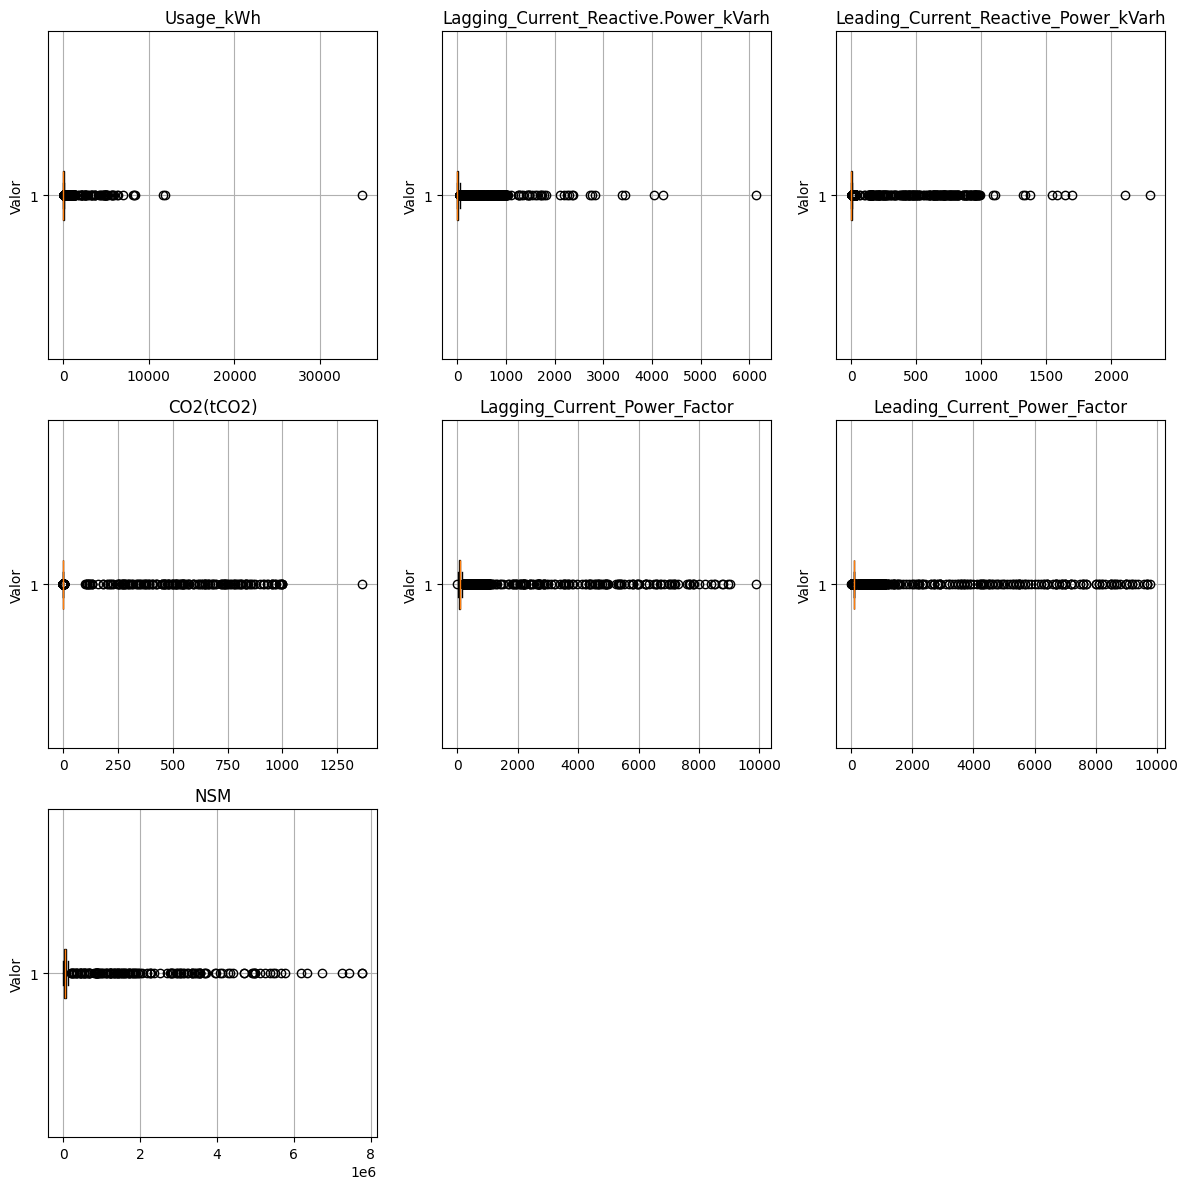

In [48]:
boxplots(df2)

In [49]:
df2_1, (lo, hi) = drop_outliers_iqr_global(df2, 'Usage_kWh', k=3.0)
print(len(df2), '→', len(df2_1), 'rows')

35740 → 35443 rows


<Axes: >

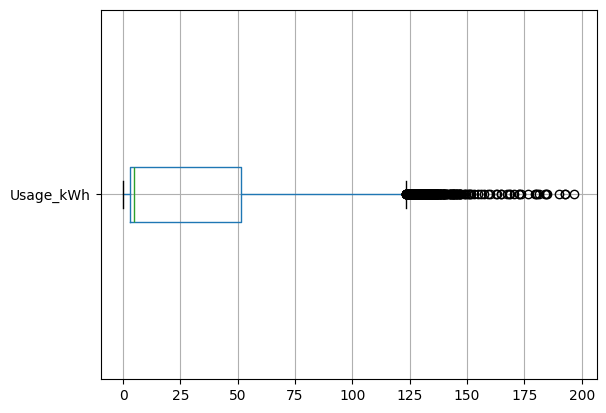

In [50]:
df2_1[['Usage_kWh']].boxplot(vert=False)

In [51]:
df2_2, (lo, hi) = drop_outliers_iqr_global(df2_1, 'Lagging_Current_Reactive.Power_kVarh', k=3.0)
print(len(df2_1), '→', len(df2_2), 'rows')

35443 → 35146 rows


<Axes: >

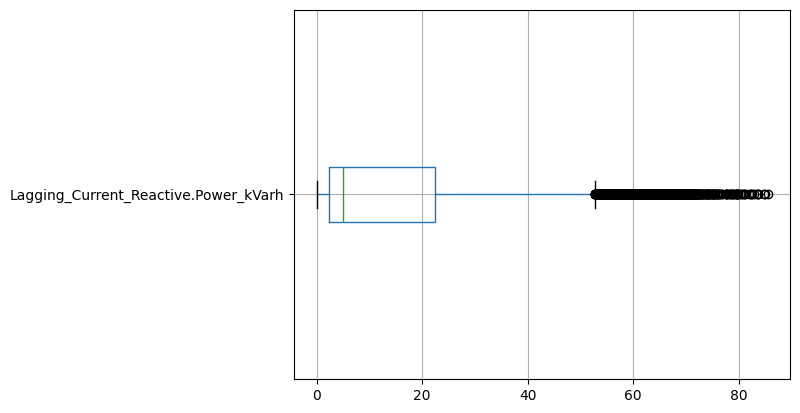

In [52]:
df2_2[['Lagging_Current_Reactive.Power_kVarh']].boxplot(vert=False)

In [53]:
df2_3, (lo, hi) = drop_outliers_iqr_global(df2_2, 'Leading_Current_Reactive_Power_kVarh', k=20)
print(len(df2_2), '→', len(df2_3), 'rows')

35146 → 34927 rows


<Axes: >

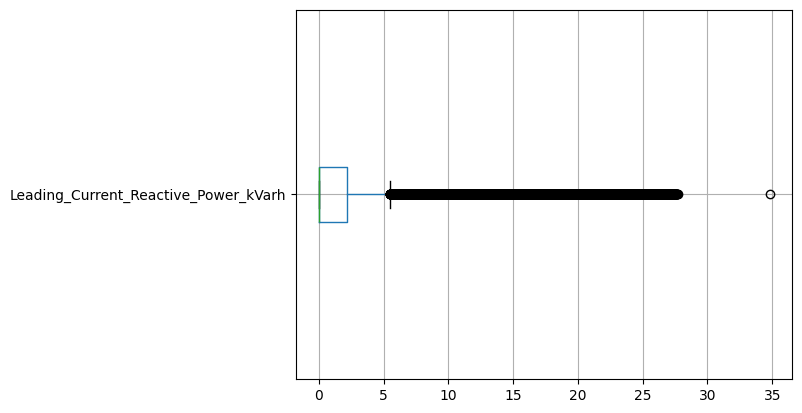

In [54]:
df2_3[['Leading_Current_Reactive_Power_kVarh']].boxplot(vert=False)

In [55]:
df2_4, (lo, hi) = drop_outliers_iqr_global(df2_3, 'CO2(tCO2)', k=3)
print(len(df2_3), '→', len(df2_4), 'rows')

34927 → 34692 rows


<Axes: >

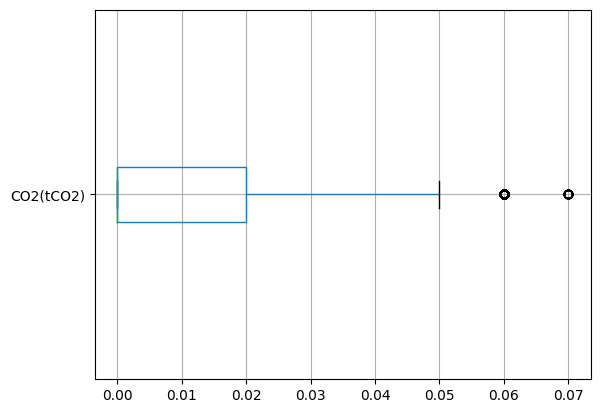

In [56]:
df2_4[['CO2(tCO2)']].boxplot(vert=False)

In [57]:
df2_5, (lo, hi) = drop_outliers_iqr_global(df2_4, 'Lagging_Current_Power_Factor', k=3)
print(len(df2_4), '→', len(df2_5), 'rows')

34692 → 34368 rows


<Axes: >

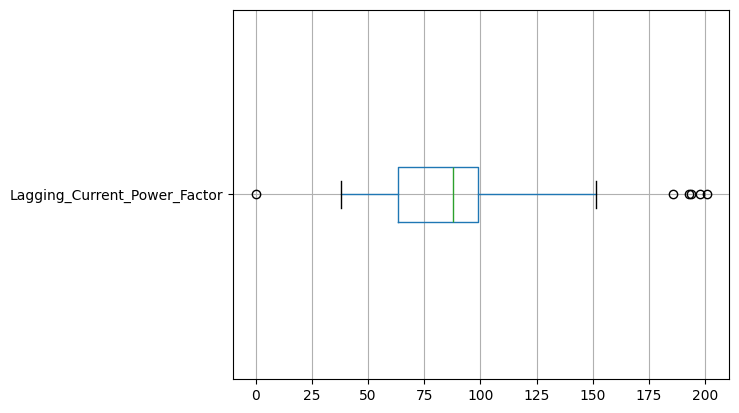

In [58]:
df2_5[['Lagging_Current_Power_Factor']].boxplot(vert=False)

In [59]:
df2_6, (lo, hi) = drop_outliers_iqr_global(df2_5, 'Leading_Current_Power_Factor', k=300)
print(len(df2_5), '→', len(df2_6), 'rows')

34368 → 34024 rows


<Axes: >

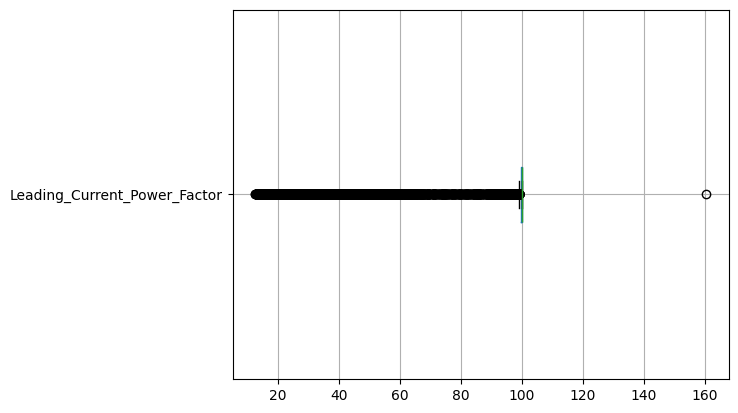

In [60]:
df2_6[['Leading_Current_Power_Factor']].boxplot(vert=False)

In [61]:
df2_7 = df2_6[df2_6['NSM'] <= 86399].copy()
print(len(df2_6), '→', len(df2_7), 'rows')

34024 → 33355 rows


<Axes: >

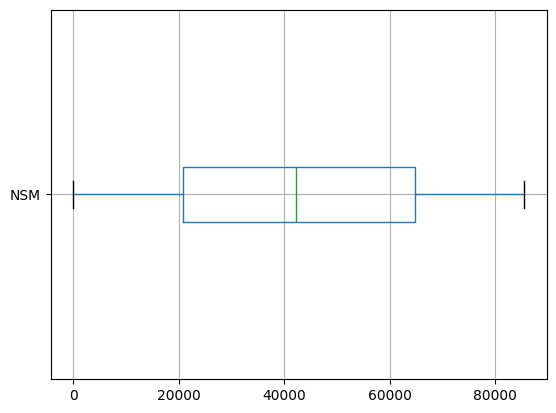

In [62]:
df2_7[['NSM']].boxplot(vert=False)

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'Usage_kWh'}>,
        <Axes: title={'center': 'Lagging_Current_Reactive.Power_kVarh'}>],
       [<Axes: title={'center': 'Leading_Current_Reactive_Power_kVarh'}>,
        <Axes: title={'center': 'CO2(tCO2)'}>,
        <Axes: title={'center': 'Lagging_Current_Power_Factor'}>],
       [<Axes: title={'center': 'Leading_Current_Power_Factor'}>,
        <Axes: title={'center': 'NSM'}>, <Axes: >]], dtype=object)

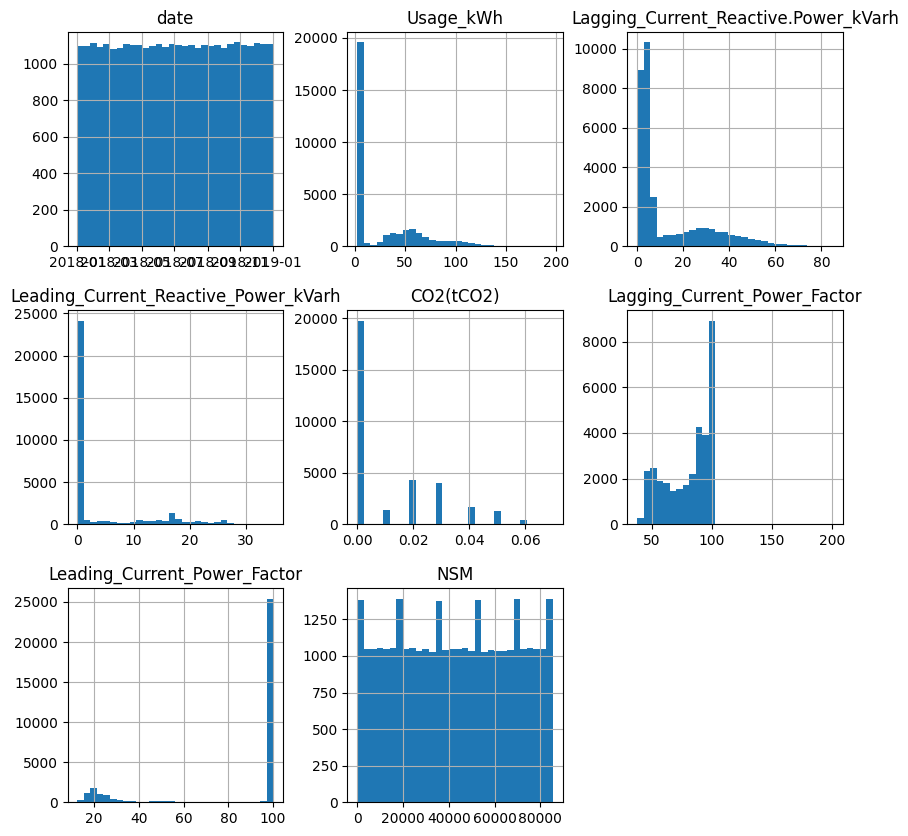

In [63]:
df2_7.hist(figsize=(10, 10), bins=30, log=False)

In [64]:
df3 = df2_7.copy()

#Categorical variables

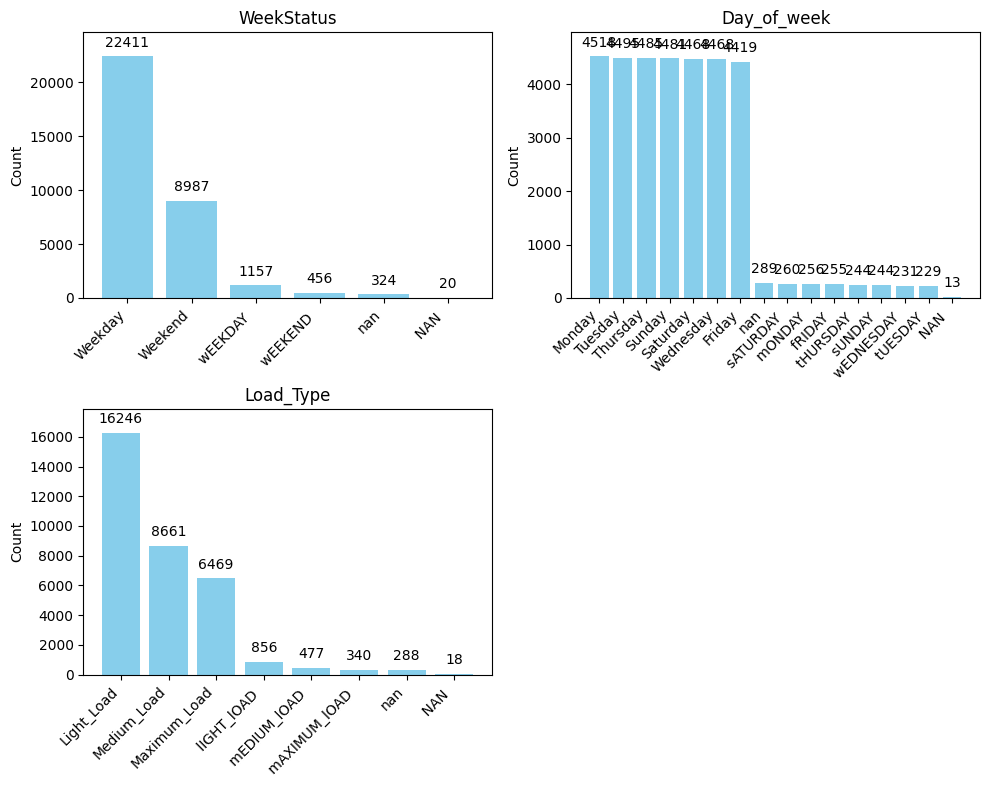

In [65]:
barplots_for_categoricals(df3, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], n_cols=2, figsize_per_plot=(5, 4))

In [66]:
weekday_mapping = {
    'wEEKDAY':'Weekday',
    'wEEKEND':'Weekend',
    'NAN' : np.nan
}
df3['WeekStatus'] = df2_7['WeekStatus'].str.strip().replace(weekday_mapping)

day_of_week_mapping = {
    'mONDAY': 'Monday',
    'tUESDAY': 'Tuesday',
    'wEDNESDAY': 'Wednesday',
    'tHURSDAY': 'Thursday',
    'fRIDAY': 'Friday',
    'sATURDAY': 'Saturday',
    'sUNDAY': 'Sunday',
    'NAN' : np.nan
}
df3['Day_of_week'] = df2_7['Day_of_week'].str.strip().replace(day_of_week_mapping)

load_type_mapping = {
    'lIGHT_lOAD': 'Light_Load',
    'mEDIUM_lOAD': 'Medium_Load',
    'mAXIMUM_lOAD': 'Maximum_Load',
    'NAN' : np.nan
}
df3['Load_Type'] = df2_7['Load_Type'].str.strip().replace(load_type_mapping)

In [67]:
#df2['WeekStatus'].value_counts()
#df2['Day_of_week'].value_counts()
#df2['Load_Type'].value_counts()

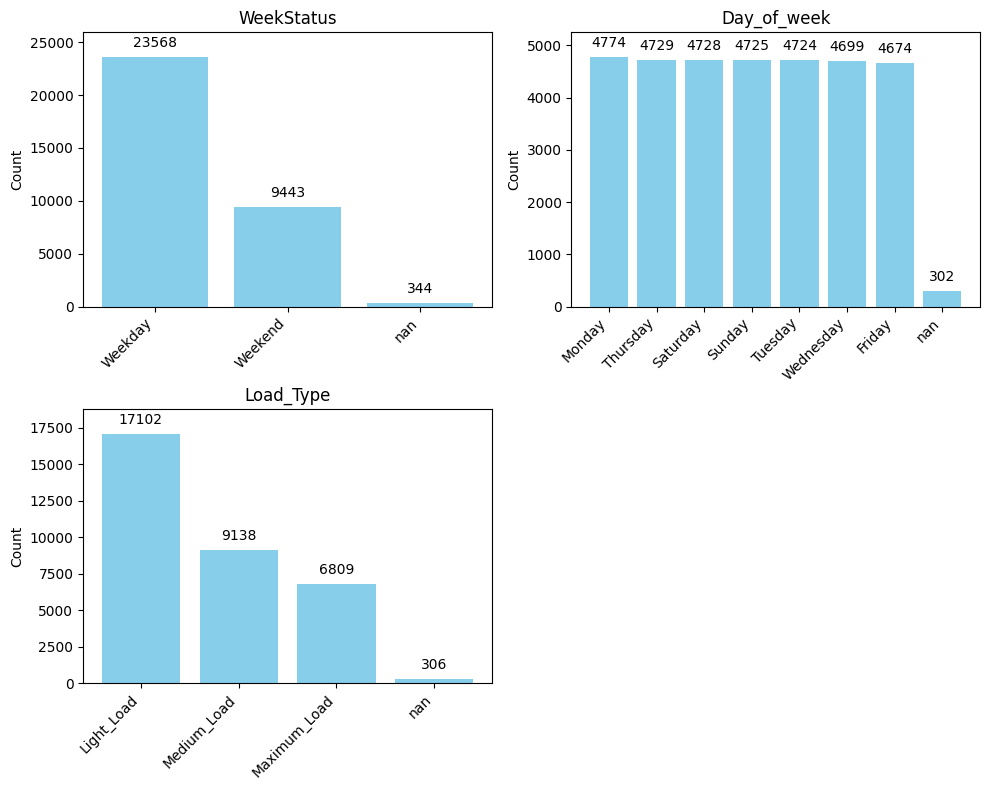

In [68]:
barplots_for_categoricals(df3, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], n_cols=2, figsize_per_plot=(5, 4))

In [69]:
df3.describe(include='object').T

,count,unique,top,freq
WeekStatus,33011,2,Weekday,23568
Day_of_week,33053,7,Monday,4774
Load_Type,33049,3,Light_Load,17102


In [70]:
df3.head(5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,NaN,73.21,100.0,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [71]:
df4 = df3.dropna()

In [72]:
df4.describe().T

,count,mean,min,25%,50%,75%,max,std
date,29265,2018-07-02 18:14:24.541260800,2018-01-01 00:00:00,2018-04-02 12:00:00,2018-07-03 07:15:00,2018-10-01 19:45:00,2018-12-31 23:45:00,NaN
Usage_kWh,29265.0,27.388869,2.45,3.2,4.57,50.98,196.67,33.686046
Lagging_Current_Reactive.Power_kVarh,29265.0,12.916007,0.0,2.2,4.97,22.28,84.96,16.255127
Leading_Current_Reactive_Power_kVarh,29265.0,3.926283,0.0,0.0,0.0,2.41,34.8,7.467095
CO2(tCO2),29265.0,0.011407,0.0,0.0,0.0,0.02,0.07,0.016097
Lagging_Current_Power_Factor,29265.0,80.60728,37.87,63.22,87.99,99.2,200.84,19.027194
Leading_Current_Power_Factor,29265.0,84.169893,12.5,99.63,100.0,100.0,100.0,30.610981
NSM,29265.0,42721.327934,0.0,20700.0,42300.0,63900.0,85500.0,24934.941348


In [73]:
missing_percentage(df4)

,0
date,0.0
Usage_kWh,0.0
Lagging_Current_Reactive.Power_kVarh,0.0
Leading_Current_Reactive_Power_kVarh,0.0
CO2(tCO2),0.0
Lagging_Current_Power_Factor,0.0
Leading_Current_Power_Factor,0.0
NSM,0.0
WeekStatus,0.0
Day_of_week,0.0


In [74]:
save_df_to_csv(df4, '/content/drive/MyDrive/Colab Notebooks/MLOps/Proyecto/Dataset/steel_energy_modified_clean.csv', date_cols=["date"])

✅ DataFrame guardado exitosamente en: /content/drive/MyDrive/Colab Notebooks/MLOps/Proyecto/Dataset/steel_energy_modified_clean.csv


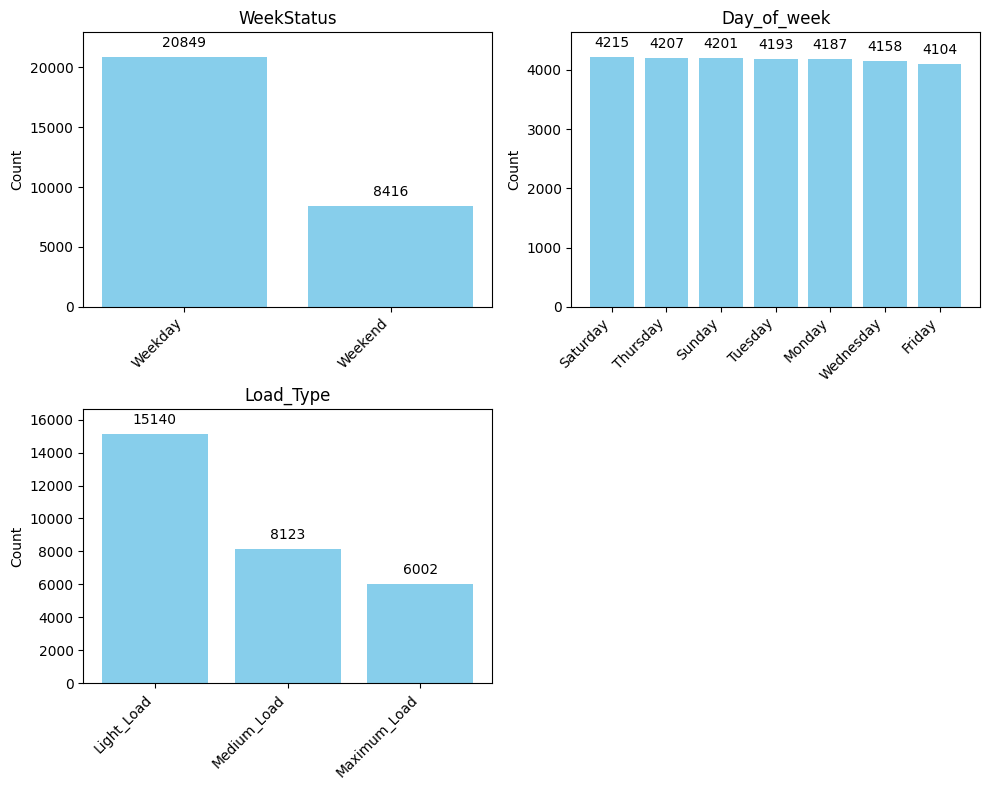

In [75]:
barplots_for_categoricals(df4, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], n_cols=2, figsize_per_plot=(5, 4))

#Categoric Variables Codification

In [76]:
df5 = df4.copy()

In [77]:
df5.tail(2)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
35738,2018-01-31 13:45:00,123.88,44.75,0.0,0.06,94.05,100.0,49500,Weekday,Wednesday,Medium_Load
35739,2018-02-11 22:30:00,3.64,3.53,0.0,0.00,71.79,100.0,81000,Weekend,Sunday,Light_Load


In [78]:
df5['WeekStatus'].value_counts()

,count
WeekStatus,
Weekday,20849
Weekend,8416


In [79]:
# Split data into training and testing sets
X = df5.drop('Usage_kWh', axis=1)
y = df5['Usage_kWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (23412, 10) (23412,)
Testing set shape: (5853, 10) (5853,)


In [ ]:
pre = ColumnTransformer(
    transformers=[
        ('numeric_cols', Pipeline([
            ('Standard_Scaler', StandardScaler())
        ]), ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']),
        ('Day_of_week_oh', Pipeline([
            ('ohe', OneHotEncoder(
              categories=[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']],
              drop='first',
              sparse_output=False))
        ]), ['Day_of_week']),
        ('WeekStatus_bi', Pipeline([ # produce 1 col: Weekend=0, Weekday=1
            ('bin', OneHotEncoder(
                categories=[['Weekend', 'Weekday']],
                drop='first',
                sparse_output=False
              ))
        ]), ['WeekStatus']),
        ('LoadType_ord', Pipeline([
            ('ord', OrdinalEncoder(
                categories=[['Light_Load','Medium_Load','Maximum_Load']],
                dtype=np.int8,
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ))
        ]), ['Load_Type'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [ ]:
df5[['Day_of_week', 'WeekStatus', 'Load_Type']].iloc[120:130]

,Day_of_week,WeekStatus,Load_Type
142,Tuesday,Weekday,Maximum_Load
144,Tuesday,Weekday,Medium_Load
145,Tuesday,Weekday,Medium_Load
146,Tuesday,Weekday,Medium_Load
147,Tuesday,Weekday,Medium_Load
149,Tuesday,Weekday,Medium_Load
150,Tuesday,Weekday,Medium_Load
151,Tuesday,Weekday,Medium_Load
152,Tuesday,Weekday,Medium_Load
154,Tuesday,Weekday,Medium_Load


In [ ]:
df5[['Day_of_week', 'WeekStatus', 'Load_Type']].head(5)

,Day_of_week,WeekStatus,Load_Type
1,Monday,Weekday,Light_Load
2,Monday,Weekday,Light_Load
3,Monday,Weekday,Light_Load
4,Monday,Weekday,Light_Load
5,Monday,Weekday,Light_Load


In [ ]:
df5[['Day_of_week', 'WeekStatus', 'Load_Type']].tail(5)

,Day_of_week,WeekStatus,Load_Type
35735,Wednesday,Weekday,Light_Load
35736,Sunday,Weekend,Light_Load
35737,Tuesday,Weekday,Light_Load
35738,Wednesday,Weekday,Medium_Load
35739,Sunday,Weekend,Light_Load


In [ ]:
# Apply the ColumnTransformer to a sample of the data
transformed_data = pre.fit_transform(df5[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'Day_of_week', 'WeekStatus', 'Load_Type']].tail(5))

# Display the transformed data
display(transformed_data)

array([[-0.46476898,  0.        , -0.5       , -1.32149731,  0.        ,
        -0.87690218,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [-0.52673818,  0.        , -0.5       , -0.34430942,  0.        ,
        -0.81335855,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ],
       [-0.45113576,  0.        , -0.5       ,  0.06941583,  0.        ,
        -0.59095582,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [ 1.99850663,  0.        ,  2.        ,  1.76153479,  0.        ,
         0.58460146,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ],
       [-0.5558637 ,  0.        , -0.5       , -0.16514389,  0.        ,
         1.6966151 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.  